# Notebook 23: Interpolating the SFR corrections from Chruslinska et al. (2020)

Because calculating the corrections for the Kroupa IMF based SFR for the IGIMF requires calculating teh $\mathrm{H}\alpha$ luminosity of a galaxy which is beyond our current scope, we rely on the publicly provided corrections from Cruslinska et al. (2020) in order to correct our results. The available data includes a dense list of corrections for $[\mathrm{Fe/H}]$ metallicities between -3 and 1, and for Kroupa SFRs between $10^{-3.3}\mathrm{M}_\odot\mathrm{ yr}^{-1}$ and $10^{3.3}\mathrm{M}_\odot\mathrm{ yr}^{-1}$. This allows us to safely interpolate any other pair of values within that range, but it also forbids from going outside of it. This is particularly limiting for lighter galaxies (small SFR) at high redshift, which can have $[\mathrm{Fe/H}]<-3$, as we will see below.

## Prelude

In [1]:
import numpy as np
import tables as tb
import warnings
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from pathlib import Path
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

In [2]:
ROOT = Path('../Data')

In [3]:
J18_FOLDER = Path(ROOT, 'J18_Results')
C19_FOLDER = Path(ROOT, 'C19_Results')
C20_FOLDER = Path(ROOT, 'C20_Results')

## Corrections

#### Converting $Z_{O/H}$ to [Fe/H]

Because the SFR from Cruslinska et al. (2019) is a function of metallicity through $Z_\mathrm{O/H}$ while the IMF from Jerabkova et al. (2018) is a function of metallicity thorugh $[\mathrm{Fe/H}]$, there is a need to convert between the two. This relation is not trivial, and a simple expression which tries to take this into account is employed.

In [4]:
ZOH_sun = 8.83

def FeH_to_OFe(FeH):
    if FeH < -1:
        return 0.5
    else:
        return -0.5*FeH
    
def FeH_from_ZOH(FeH, ZOH):
    OFe = FeH_to_OFe(FeH)
    return FeH - ZOH + ZOH_sun + OFe    

def ZOH_to_FeH(ZOH):
    [FeH] = fsolve(FeH_from_ZOH, (-1), args=(ZOH))
    return FeH

#### Loading the data

In [5]:
corrections_path = Path(C20_FOLDER, 'IGIMF3_SFR_corrections.dat')

In [6]:
correction_data = np.loadtxt(corrections_path, unpack='True').T

In [7]:
FeHs = []
SFRKs = []
SFRCs = []
SFRK = []
SFRC = []
for row in correction_data:
    if row[0] not in FeHs:
        SFRKs.append(SFRK)
        SFRCs.append(SFRC)
        SFRK = []
        SFRC = []
        FeHs.append(row[0])
    SFRK.append(row[1])
    SFRC.append(row[2])
SFRKs.append(SFRK)
SFRCs.append(SFRC)
SFRKs.pop(0)
SFRCs.pop(0)

FeHs = np.array(FeHs)
SFRKs = np.array(SFRKs[0])
SFRCs = np.array(SFRCs)

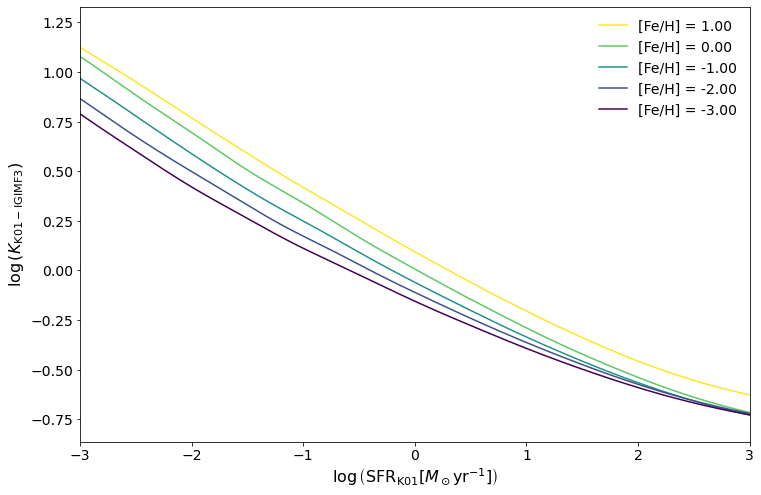

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(FeHs) - min(FeHs)

for i, FeH in enumerate(FeHs):
    ax.plot(SFRKs, SFRCs[i], '-', c=cm.viridis((FeH-min(FeHs))/color_norm), label=f'[Fe/H] = {FeH:.2f}')

ax.set_xlim(-3,3)
    
ax.set_xlabel(r'$\log\left(\mathrm{SFR}_\mathrm{K01}[M_\odot\mathrm{yr}^{-1}]\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(K_\mathrm{K01-IGIMF3}\right)$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False)

#### Interpolating the data

In [9]:
interpolX = []
interpolY = []

for i in range(SFRCs.shape[1]):
    interpolX.append(FeHs)
    interpolY.append(SFRCs[:,i])
    
interpolX = np.array(interpolX)
interpolY = np.array(interpolY)

Text(0, 0.5, '$\\log\\left(K_\\mathrm{K01-IGIMF3}\\right)$')

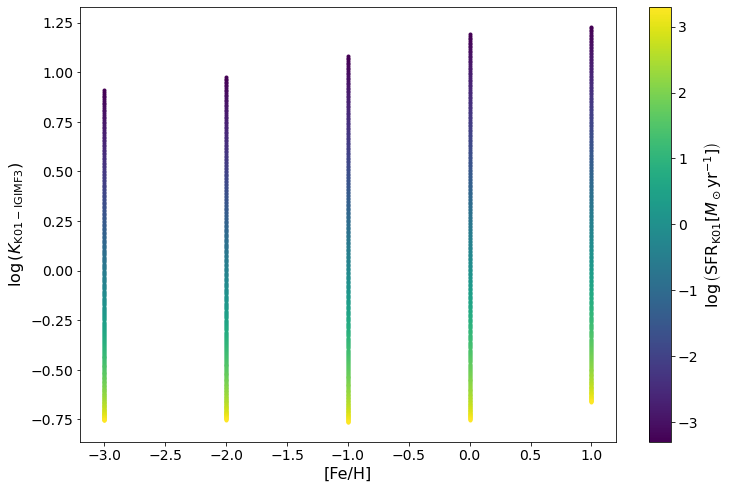

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(SFRKs)-min(SFRKs)

for i, SFRK in enumerate(SFRKs):
    ax.plot(interpolX[i], interpolY[i], '.', c=cm.viridis((SFRK-min(SFRKs))/color_norm))
    
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(SFRKs), vmax=max(SFRKs)))
cb = fig.colorbar(sm)

cb.set_label(label=r'$\log\left(\mathrm{SFR}_\mathrm{K01}[M_\odot\mathrm{yr}^{-1}]\right)$', size=16)
cb.ax.tick_params(labelsize=14)

ax.tick_params(axis='both', labelsize=14)

ax.set_xlabel('[Fe/H]', fontsize=16)
ax.set_ylabel(r'$\log\left(K_\mathrm{K01-IGIMF3}\right)$', fontsize=16)

In [11]:
sampleinterpolX = interpolX[np.arange(0,len(interpolX),29)]
sampleinterpolY = interpolY[np.arange(0,len(interpolX),29)]
sampleSFRKs = SFRKs[np.arange(0,len(interpolX),29)]

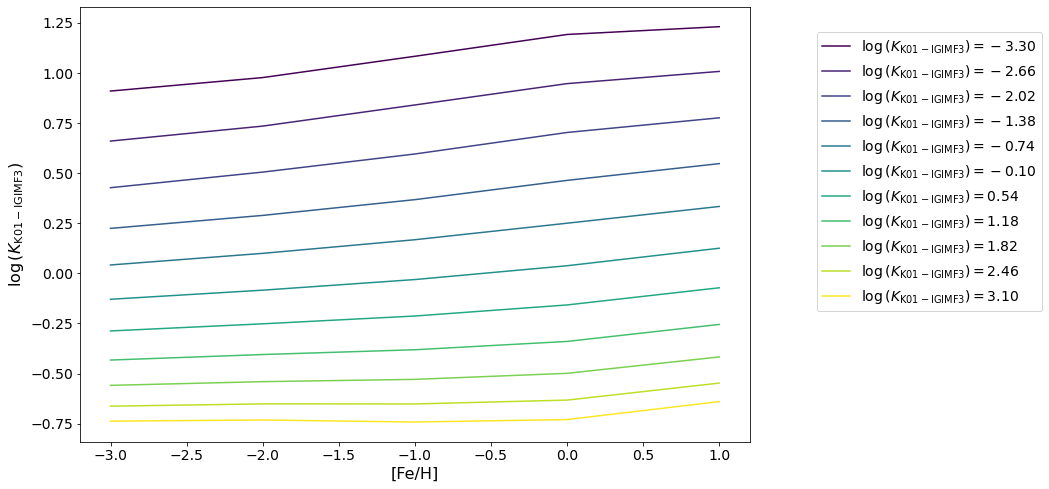

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(sampleSFRKs)-min(sampleSFRKs)

for i, SFRK in enumerate(sampleSFRKs):
    ax.plot(sampleinterpolX[i], sampleinterpolY[i], '-', c=cm.viridis((SFRK-min(sampleSFRKs))/color_norm), label=r'$\log\left(K_\mathrm{K01-IGIMF3}\right)=%.2f$'%SFRK)
    
ax.set_xlabel('[Fe/H]', fontsize=16)
ax.set_ylabel(r'$\log\left(K_\mathrm{K01-IGIMF3}\right)$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(loc=(1.1, 0.3), fontsize=14)

In [13]:
interpoledX = []
interpoledY = []

for i in range(len(interpolX)):
    f = interp1d(interpolX[i], interpolY[i], kind='cubic')
    interpoledx = np.linspace(-3, 1, 10)
    interpoledy = f(interpoledx)
    
    interpoledX.append(interpoledx)
    interpoledY.append(interpoledy)
    
interpoledX = np.array(interpoledX)
interpoledY = np.array(interpoledY)

Text(0, 0.5, '$\\log\\left(K_\\mathrm{K01-IGIMF3}\\right)$')

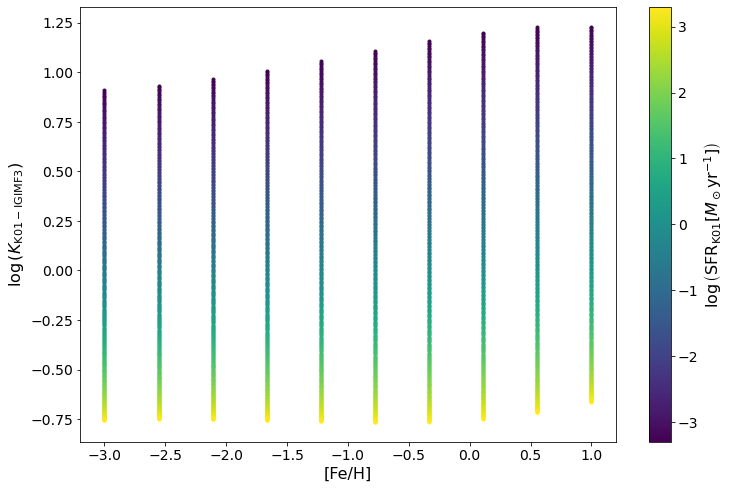

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(SFRKs)-min(SFRKs)

for i, SFRK in enumerate(SFRKs):
    ax.plot(interpoledX[i], interpoledY[i], '.', c=cm.viridis((SFRK-min(SFRKs))/color_norm))
    
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(SFRKs), vmax=max(SFRKs)))
cb = fig.colorbar(sm)

cb.set_label(label=r'$\log\left(\mathrm{SFR}_\mathrm{K01}[M_\odot\mathrm{yr}^{-1}]\right)$', size=16)
cb.ax.tick_params(labelsize=14)

ax.tick_params(axis='both', labelsize=14)

ax.set_xlabel('[Fe/H]', fontsize=16)
ax.set_ylabel(r'$\log\left(K_\mathrm{K01-IGIMF3}\right)$', fontsize=16)

In [15]:
sampleinterpoledX = interpoledX[np.arange(0,len(interpoledX),29)]
sampleinterpoledY = interpoledY[np.arange(0,len(interpoledX),29)]
sampleSFRKs = SFRKs[np.arange(0,len(interpolX),29)]

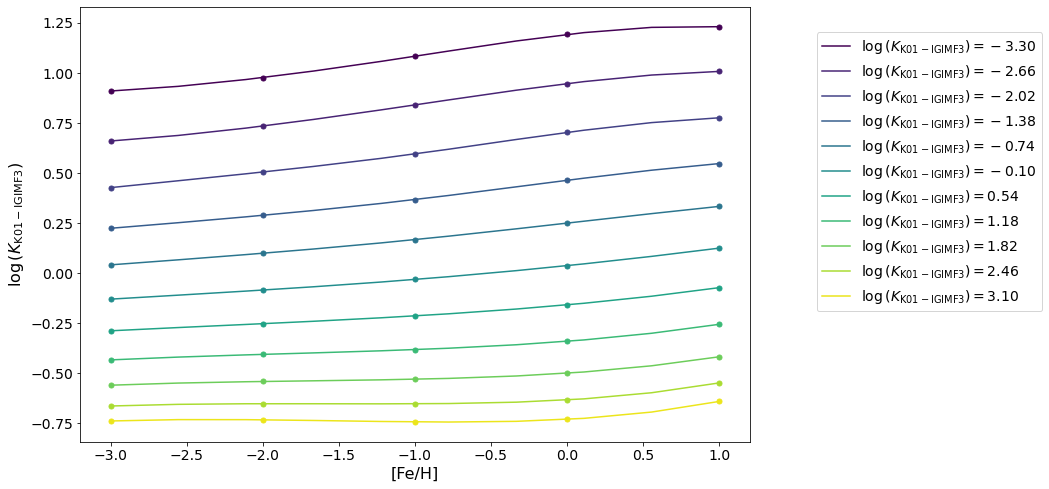

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

for i, SFRK in enumerate(sampleSFRKs):
    ax.plot(sampleinterpolX[i], sampleinterpolY[i], '.', markersize=10, c=cm.viridis((SFRK-min(sampleSFRKs))/color_norm))
    ax.plot(sampleinterpoledX[i], sampleinterpoledY[i], '-', c=cm.viridis((SFRK-min(sampleSFRKs))/color_norm), label=r'$\log\left(K_\mathrm{K01-IGIMF3}\right)=%.2f$'%SFRK)
    
ax.set_xlabel('[Fe/H]', fontsize=16)
ax.set_ylabel(r'$\log\left(K_\mathrm{K01-IGIMF3}\right)$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(loc=(1.1, 0.3), fontsize=14)

In [17]:
ipSFRCs = []
ipFeHs = []
for i in range(len(interpoledX[0])):
    feh = interpoledX[:,i][0]
    sfrcs = [sfrc for sfrc in interpoledY[:,i]]
    ipFeHs.append(feh)
    ipSFRCs.append(sfrcs)

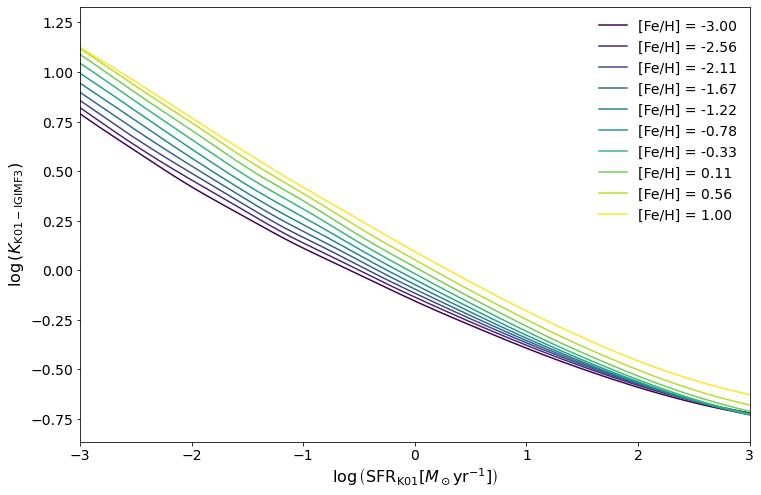

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(ipFeHs) - min(ipFeHs)

for i, FeH in enumerate(ipFeHs):
    ax.plot(SFRKs, ipSFRCs[i], '-', c=cm.viridis((FeH-min(ipFeHs))/color_norm), label=f'[Fe/H] = {FeH:.2f}')

ax.set_xlim(-3,3)
    
ax.set_xlabel(r'$\log\left(\mathrm{SFR}_\mathrm{K01}[M_\odot\mathrm{yr}^{-1}]\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(K_\mathrm{K01-IGIMF3}\right)$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False)